# 1. Data Collection

## 1.1 Load Necessary libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score ,classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

## 1.2 Load The Data from csv

In [3]:
# Load the dataset
data = pd.read_csv('weatherAUS.csv')
data.describe(include='all')

# Check the columns
print(data.columns.tolist())  # This will confirm the names

# Inspect the data
print(data.info())
print(data.describe())
print(data.isnull().sum())


['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RISK_MM', 'RainTomorrow']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 no

# 2. Data Cleaning & Preparation

##  Handling The Missing Values & Feature Engineering

In [4]:
# Drop rows with missing target
data.dropna(subset=['RainTomorrow'], inplace=True)

# Fill missing values for numerical columns with mean and categorical with mode
for column in data.columns:
    if data[column].isnull().any():
        if data[column].dtype == 'object':
            data[column] = data[column].fillna(data[column].mode()[0])  # Fill categorical with mode
        else:
            data[column] = data[column].fillna(data[column].mean())  # Fill numerical with mean


# Convert categorical features to dummy variables
data = pd.get_dummies(data, columns=['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'], drop_first=True)

# Convert date column and extract features (into month and day columns)
data['Date'] = pd.to_datetime(data['Date'])
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.dayofweek

# Define features and target
X = data.drop(['RainTomorrow', 'Date'], axis=1)  # Features
y = data['RainTomorrow']

# Scale numerical features
scaler = StandardScaler()
X[X.select_dtypes(include=['float64', 'int64']).columns] = scaler.fit_transform(X.select_dtypes(include=['float64', 'int64']))

# Check the data types in X
print("Data types in X:")
print(X.dtypes)

# Identify non-numeric columns (check before dropping)
non_numeric_columns = X.select_dtypes(exclude=['number']).columns.tolist()
if non_numeric_columns:
  print("Non-numeric columns detected:", non_numeric_columns)
  X.drop(columns=non_numeric_columns, inplace=True)

# Check for NaN values in features
print("Missing values in X:")
print(X.isnull().sum())

# Drop rows with NaN values in features
X.dropna(inplace=True)

# Align y with the filtered X
y = y[X.index]

# Ensure all columns in X are numeric
if not all(X.dtypes.apply(lambda x: pd.api.types.is_numeric_dtype(x))):
    raise ValueError("There are still non-numeric columns in X.")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Data types in X:
MinTemp           float64
MaxTemp           float64
Rainfall          float64
Evaporation       float64
Sunshine          float64
                   ...   
WindDir3pm_W         bool
WindDir3pm_WNW       bool
WindDir3pm_WSW       bool
month               int32
day                 int32
Length: 113, dtype: object
Non-numeric columns detected: ['RainToday', 'Location_Albany', 'Location_Albury', 'Location_AliceSprings', 'Location_BadgerysCreek', 'Location_Ballarat', 'Location_Bendigo', 'Location_Brisbane', 'Location_Cairns', 'Location_Canberra', 'Location_Cobar', 'Location_CoffsHarbour', 'Location_Dartmoor', 'Location_Darwin', 'Location_GoldCoast', 'Location_Hobart', 'Location_Katherine', 'Location_Launceston', 'Location_Melbourne', 'Location_MelbourneAirport', 'Location_Mildura', 'Location_Moree', 'Location_MountGambier', 'Location_MountGinini', 'Location_Newcastle', 'Location_Nhil', 'Location_NorahHead', 'Location_NorfolkIsland', 'Location_Nuriootpa', 'Location_PearceRAA

# 3. Algorithm Understanding Model Development

In [5]:
# Initialize model
model = RandomForestClassifier()

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
}

# Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)


Best parameters found:  {'max_depth': None, 'n_estimators': 100}


# 4. Model Evaluation

[[22098     0]
 [    0  6341]]
              precision    recall  f1-score   support

          No       1.00      1.00      1.00     22098
         Yes       1.00      1.00      1.00      6341

    accuracy                           1.00     28439
   macro avg       1.00      1.00      1.00     28439
weighted avg       1.00      1.00      1.00     28439

ROC AUC Score: 1.0000


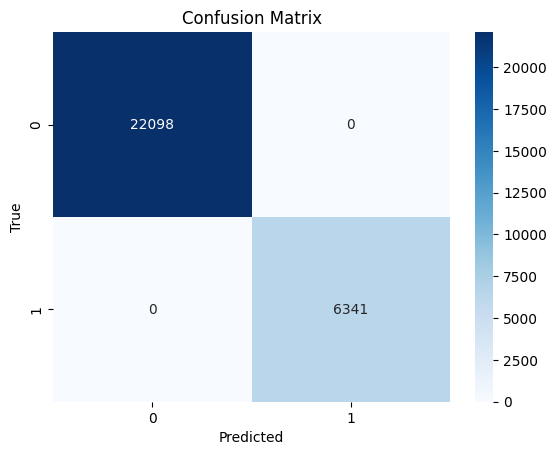

In [6]:
# Make predictions
y_pred = best_model.predict(X_test)

# Evaluate model
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Calculate and print additional evaluation metrics
roc_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"ROC AUC Score: {roc_auc:.4f}")

# Visualize confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()